In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
from math import sqrt
from dateutil import parser

%matplotlib inline

base_url = 'https://raw.githubusercontent.com/aisaacso/SafeBoss/master/'
crime_url = base_url + 'Crime_Incident_Reports.csv'
crime = pd.read_csv(crime_url)

# Converts FROMDATE from str to datetime
crime['FROMDATE'] = pd.to_datetime(crime.FROMDATE, format = '%m/%d/%Y %I:%M:%S %p')

# Lops off data from July, 2012 to August, 2012, so that we have full years
crime = crime[crime.FROMDATE > '2012-08-10 00:00:00']

#Add a date column
crime['Date'] = crime.FROMDATE.dt.date

/Users/annaisaacson/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


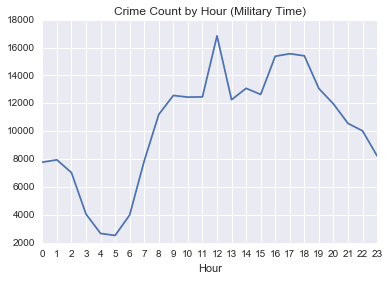

In [2]:
# Analysis of crime time of day

#Confirms no nulls in FROMDATE
#crime_nulls = crime[crime.FROMDATE.isnull()==True]
#crime_nulls

# Overrides a warning that I don't really understand; should look into it more
pd.options.mode.chained_assignment = None

# Adds Hour column for each crime
crime['Hour'] = crime.FROMDATE.dt.hour

# Removes the rows that have no time -- probably needlessly complex!
crime_no_time = crime[(crime.FROMDATE.dt.hour == 0) & (crime.FROMDATE.dt.minute == 0)]
crime_no_time['no_time'] = 'indicator'
crime_time = crime.merge(crime_no_time, how='left')
crime_time = crime_time[crime_time.no_time <> 'indicator']

# Pivot table of count conditioned on hour
hours = pd.pivot_table(crime_time, values = 'DAY_WEEK', index = 'Hour', aggfunc = 'count')

#Plots the total number of crimes at each time of day
hours.plot(xticks = crime.Hour.unique(), title='Crime Count by Hour (Military Time)')

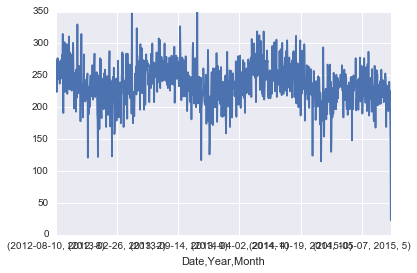

In [3]:
# Analysis crime time of year
months = pd.pivot_table(crime, values = 'DAY_WEEK', index = 'Month', aggfunc = 'count')

# Attempt at creating time series, based on http://earthpy.org/pandas-basics.html
#dates = pd.date_range('2012-08-10 00:00:00', '2015-08-10 23:59:00', freq='H')

#Plots crimes per day
dates = pd.pivot_table(crime, values = 'DAY_WEEK', index = ['Date', 'Year', 'Month'], aggfunc = 'count')
dates.plot()

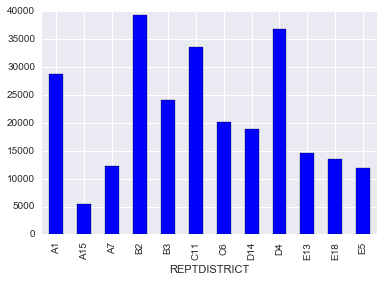

In [15]:
# Shows which districts have the most crime

crime_no_HTU = crime[crime.REPTDISTRICT <> 'HTU']
reptd = pd.pivot_table(crime_no_HTU, values = 'DAY_WEEK', index = 'REPTDISTRICT', aggfunc = 'count')
reptd.plot(kind = 'bar', sort_columns = True)